In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2022-09-09 10:30:09.577755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 10:30:09.577794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from preprocess import get_principle_components_and_EOFs
import os
import visualization
import models

In [3]:
%load_ext autoreload
%autoreload

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

In [5]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import time

In [6]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [8]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

Frozen(SortedKeysDict({'latitude': 28, 'longitude': 31}))

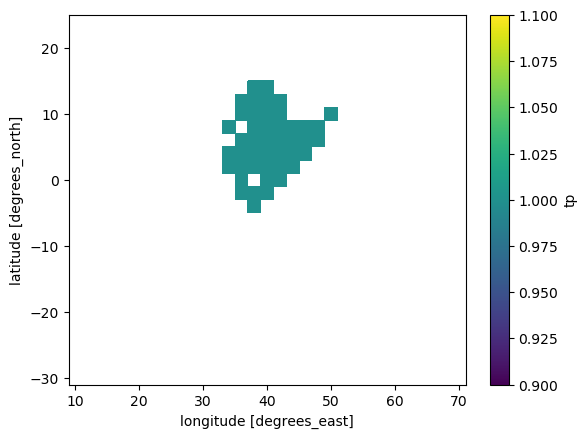

In [9]:
# Import regional mask
root_data = '/data/volume_2/observational/raw/'

import pathlib
root_results = str(pathlib.Path.home() / 'Results')

file = '/data/volume_2/observational/era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

In [10]:
SYY = 1980   # start year, could be changed
EYY = 2021   # end year, could be changed


drop_OND_years = [2005,2007,2018,2004,2006]
take_OND_years = list(np.arange(SYY,EYY+1))
take_OND_years = [y for y in take_OND_years if y not in drop_OND_years]
# drop_MAM_years = [2009,2001,2002,2005,2020]

In [11]:
# Calculate the spatial mean of the tp file after applying the spatial mask

file=xr.open_mfdataset(root_data+f'/era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate 33 percentile
# Create daily values equal to a 31 day rolling. Select OND 2000-2020 data to decide the quantile threshold
tp_rol=tp_series.rolling(time=28, center=False).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_quantile=tp_rol.sel(time=tp_rol.time.dt.month.isin([10,11,12])).quantile(0.33)
print('value of the 33 percentile',tp_quantile.tp.values)


# Create index time series
# Replace the values bellow the 33 percentile with 1 and the rest with zeros
tp_rol = tp_series.rolling(time=28, center=False).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol_sel = tp_rol.sel(time = slice(str(SYY),str(EYY)))
tp_index = tp_rol_sel < tp_quantile
tp_index = tp_index.sel(time=tp_index.time.dt.year.isin(take_OND_years))
tp_index = tp_index.astype(int)
print('tp index',tp_index)

value of the 33 percentile 0.00035814421308087555
tp index <xarray.Dataset>
Dimensions:   (time: 3404)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-01 1980-10-02 ... 2021-12-31
    quantile  float64 0.33
Data variables:
    tp        (time) int64 dask.array<chunksize=(3404,), meta=np.ndarray>


number of 0 and 1:  (array([0, 1]), array([1920,  374]))
<xarray.Dataset>
Dimensions:   (time: 2294)
Coordinates:
    quantile  float64 0.33
  * time      (time) datetime64[ns] 1980-10-01 1980-10-02 ... 2021-12-01
Data variables:
    tp        (time) int64 dask.array<chunksize=(62,), meta=np.ndarray>
(2294,)


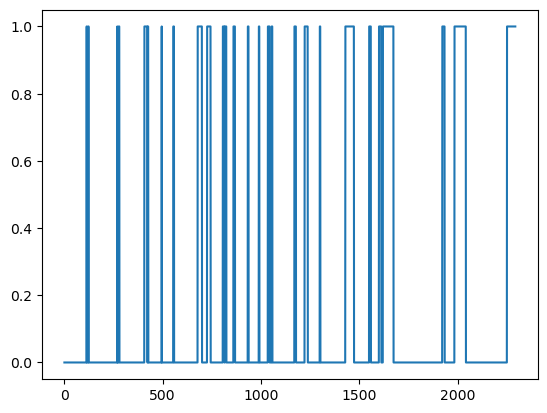

In [12]:
# Select from the index time series the period for the target values (predictant) 
# Oct 16 to Dec 16 for the period 1980-2020 (each day corresponds to a 31-day rolling mean)
# The chosen time period could be changed to any time period you want
for iyr in range(SYY,EYY+1):
    if iyr == SYY:
        tp_target = tp_index.sel(time = slice(str(iyr)+'-10-01',str(iyr)+'-12-01'))
    else:
        tp_target = xr.concat([tp_target,tp_index.sel(time = slice(str(iyr)+'-10-01',str(iyr)+'-12-01'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target['tp'],return_counts=True))
print(tp_target)
plt.plot(tp_target.tp)

# Make it into a numpy array
target2 = tp_target['tp']
target = tp_target['tp'].values
print(target.shape)

In [13]:
# Predictor data preprocessing
# can select the values and region you want by changing the parameters

file_vars = ['ERA5_t2m', 'era5_t_850hpa', 'era5_z_200hpa', 'era5_z_500hpa', 'sst', 'era5_olr']
#file_vars = ['sst']
header_vars = ['t2m', 't', 'z', 'z', 'sst', 'olr-mean']
#header_vars = ['sst']

# select regions for the individual predictor
lon_slices = [[-16,54],[-30,90],[-30,90],[-30,90],[-180,180],[40,180]]
lat_slices = [[16,0],[30,-20],[-20,30],[-20,30],[40,-20],[-20,20]]

nmode = 5 # for eofs

for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    # use existing
    path = root_results+'/PC_series_n_'+str(nmode)+'_var_'+file_var+'_.nc'
    path_eof = root_results+'/EOF_maps_n_'+str(nmode)+'_var_'+file_var+'_.nc'
    
    if os.path.exists(path):
        continue
    if file_var == 'era5_olr':
        file = xr.open_dataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc')
        print('olr')
    else:
        file = xr.open_dataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc')
        print(header_var)

    if "longitude" in file.coords:
        file = file.rename({"longitude": "lon","latitude": "lat"})

    assert "lat" in file.coords
    assert "lon" in file.coords
    
    # select region
    var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
    
    # todo: train_valid_test_split: exclude test    
    # take years 1980 - 2021 daily and only and 7 day rolling mean
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
    var_series = var_series.sel(time=var_series.time.dt.year.isin(take_OND_years))

    # remove climatology
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    
    # use the months you want (base on how long the time series used as predictors)
    var_anom_sel = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))[header_var]
    
    # Apply EOF
    if file_var == "era5_z_500hpa":
        header_var = "z500"
    pc_xr, EOF = get_principle_components_and_EOFs(var_anom_sel, nmode=nmode)
    
    pc_xr = pc_xr.assign_coords(mode=[str(header_var)+'_'+str(int(m)) for m in pc_xr.mode])
    EOF = EOF.assign_coords(mode=[str(header_var)+'_'+str(int(m)) for m in EOF.mode])
    # save to disk
    pc_xr.to_netcdf(path)
    EOF.to_netcdf(path_eof)

In [14]:

from L_functions import sel_train_data_lead

#Create predictor multi-file
nc_in_file='PC_serie*.nc'
dim_to_stack='mode'
pc_xr = xr.open_mfdataset(root_results+"/"+nc_in_file,concat_dim=dim_to_stack,
                          combine="nested")# 

# Run the function
s_target_date='01-10-1980'
e_target_date='01-12-2021'
rw_1=7
lead_time=15
rw=0 # because the data are not centered
ntimestep=60
target_len=len(tp_target['tp'])

predictor_array=sel_train_data_lead(pc_xr, target_len, s_target_date, e_target_date,
                rw_1, lead_time, rw, ntimestep)

np_out_name='Predictor_array_crosscor_number.nc'

#np.save(root_results+np_out_name,predictor_array)
predictor_array.to_netcdf(root_results+"/"+np_out_name)

starting
start target date 1 10 1980
end target 1 12 2021


In [15]:
# plot EOF modes
# import cartopy.crs as ccrs
# import cartopy.feature as cf
# ii = 1
# color = 'RdBu_r' 
# colorbarMin = -1
# colorbarMax = 1
# colorspace = 0.1
# level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
# ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
# h = ax.contourf(lon, lat, EOF[ii,:,:], level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
# cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=40)
# cbar.ax.tick_params(labelsize=10) 
# colorLabel='SST EOF [K]'
# cbar.set_label(label=colorLabel,fontsize=10)
# #Add in the coordinate system:
# long = np.arange(-180, 180, 45)#spacing of 45 degrees
# latg = np.arange(-20, 40, 10)#spacing of 15 degrees
# ax.set_xticks(long, crs=ccrs.PlateCarree());
# ax.set_yticks(latg, crs=ccrs.PlateCarree());
# ax.set_xticklabels(long,fontsize=8)
# ax.set_yticklabels(latg,fontsize=8)
# ax.set_ylabel('lat',fontsize=10);
# ax.set_xlabel('lon',fontsize=10);

# #Add in the continents
# #define the coastlines, the color (#000000) and the resolution (110m) 
# feature1 = cf.NaturalEarthFeature(
#     name='coastline', category='physical',
#     scale='110m',
#     edgecolor='#000000', facecolor='none')
# #define the land, the color (#AAAAAA) and the resolution (110m), mask the land, use for SST
# feature2 = cf.NaturalEarthFeature(
#     name='land', category='physical',
#     scale='110m',
#     facecolor='#AAAAAA')

# ax.add_feature(feature2)

# #Set a title for your map:
# title = 'SST JAS EOF'+str(ii+1)
# plt.title(title,fontsize=10, y=1.03)

# fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
# plt.plot(PC[:,ii])

### Causal Inference

In [16]:
# hard fix dates intersection
dates = tp_index.tp.time.to_index().intersection(pc_xr.time.to_index()).intersection(predictor_array.time.to_index())
tp_index = tp_index.sel(time=dates).compute()
target2 = target2.sel(time=dates).compute()
pc_xr = pc_xr.sel(time=dates).compute()
predictor_array = predictor_array.sel(time=dates).compute()

In [17]:
# tofix: pc_xr.where(pc_xr.isnull().any("mode"),drop=True) shows 36 NaNs towards the end
pc_xr = pc_xr.sel(time=slice("1980","2021-10-25"))
tp_index = tp_index.sel(time=slice("1980","2021-10-25"))
target2 = target2.sel(time=slice("1980","2021-10-25"))
predictor_array = predictor_array.sel(time=slice("1980","2021-10-25"))

In [18]:

!pip install tigramite
import tigramite
import numpy as np
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn, GPDC

# Example data
features_train = pc_xr.pcs
sample_size = features_train.time.size
N_features = features_train.mode.size
allX = features_train.values # np.random.randn(sample_size, N_features)
# true_causal_features = [0, 5, 8] # unknown

# Target
y = tp_index.tp.values # np.random.randn(sample_size) + 3*allX[:, true_causal_features].mean(axis=1)

# Construct array needed for tigramite, we need to lag X behind y here just for computation reasons
data = np.hstack((y[:-1].reshape(sample_size-1, 1), allX[1:]))

# Initialize class with ParCorr test, can be changed to nonlinear CI tests, eg CMIknn, but these use more computation time
dataframe = pp.DataFrame(data, var_names = ['target',] + list(range(N_features)))
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(),  # or CMIknn()  GPDC()
    verbosity=0)

# Set alpha_level for selecting causal features, the smaller the stricter
pc_alpha = 0.01

# Only run on target variable
selected_links = [(i, -1) for i in range(1, N_features + 1)]
causal_predictors = pcmci._run_pc_stable_single(j=0,
                              selected_links=selected_links,
                              tau_min=1,
                              tau_max=1,
                              pc_alpha=pc_alpha)

# Indices of causal features from X
causal_features = [varlag[0] - 1 for varlag in causal_predictors['parents']]
print(causal_features)

eofs = xr.open_mfdataset(root_results+"/EOF_*",concat_dim=dim_to_stack,
                          combine="nested")

/home/pbommer2/.local/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/pbommer2/.local/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


[0, 5, 2, 22, 9, 23, 29, 7, 15]


## Splitting Data

In [19]:
import tensorflow.keras as keras
drop_OND_years = [2005,2007,2018,2004,2006]
drop_MAM_years = [2009,2001,2002,2005,2020]

def get_train_test_val(data_predictor, data_target, test_frac, val_frac):
    """Splits data across periods into train, test, and validation"""
    # assign the last int(-test_frac*len(tp_predictor)) rows to test data
    test_predictor = data_predictor[int(-test_frac*len(data_target)):]
    test_target = data_target[int(-test_frac*len(data_target)):]
    
    # assign the last int(-test_frac*len(tp_predictor)) from the remaining rows to validation data
    remain_predictor = data_predictor[0:int(-test_frac*len(data_target))]
    remain_target = data_target[0:int(-test_frac*len(data_target))]
    val_predictor = remain_predictor[int(-val_frac*len(remain_predictor)):]
    val_target = remain_target[int(-val_frac*len(remain_predictor)):]
    
    # the remaining rows are assigned to train data
    train_predictor = remain_predictor[:int(-val_frac*len(remain_predictor))]
    train_target = remain_target[:int(-val_frac*len(remain_predictor))]
    return train_predictor, train_target, test_predictor, test_target, val_predictor, val_target

In [20]:
# define input and output data for LSTM
y_all = keras.utils.to_categorical(target2)
X_all = predictor_array.pcs
print(X_all.shape,y_all.shape)

(2221, 60, 30) (2221, 2)


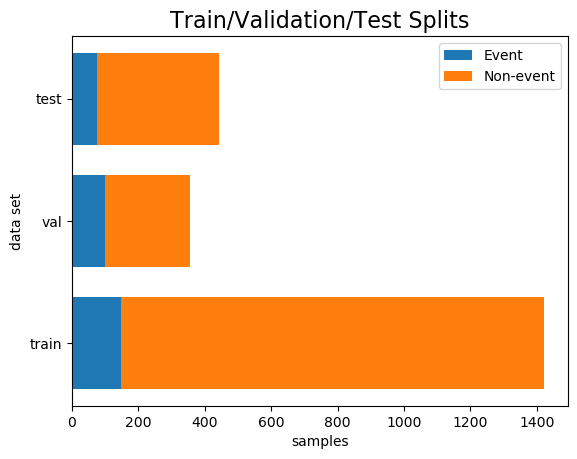

In [21]:
train_X, train_y, test_X, test_y, val_X, val_y = get_train_test_val(X_all, y_all, test_frac=0.2, val_frac=0.2)
visualization.plot_split_counts(train_y, val_y, test_y)

## Model

In [22]:
from models import build_lstm, class_weight_creator

batch_size = 32
shuffle = True 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)
class_weight = class_weight_creator(train_y)

callbacks_path = '/home/zwu/Lorentz_workshop/test/checkpoint_test'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_acc',   # tf.keras.metrics.AUC(from_logits=True)
        save_best_only=True,
    )
]

ntimestep = 60    # number of time step used in the predictors
nfeature = 30   # number of features
## SET kwargs in order to expand lstm ('layers') or change layer size ('neurons' - list of ints with neurons per layer)
hyperparams = {'regval':[1,0.1], 'neurons': [20,20],'layers': 2}

model = build_lstm(ntimestep, nfeature, **hyperparams)

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

model.summary()
# train the model
epochs = 100
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), shuffle = shuffle, verbose=verbose, class_weight=class_weight)

2022-09-09 10:30:39.729870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 10:30:39.729907: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 10:30:39.729930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyternoteboo): /proc/driver/nvidia/version does not exist
2022-09-09 10:30:39.730175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


layer 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 30)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 20)            4080      
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            3280      
                                                                 
 attention_with_context (Att  ((None, 60, 20),         440       
 entionWithContext)           (None, 60, 1))                     
                                                                 
 addition (Addition)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                     

# Evaluation

14/14 [==============================] - 0s 10ms/step
Recall: 0.84
Precision: 0.23
F1-score: 0.36
Accuracy: 0.48
Brier score:0.3135915272775873


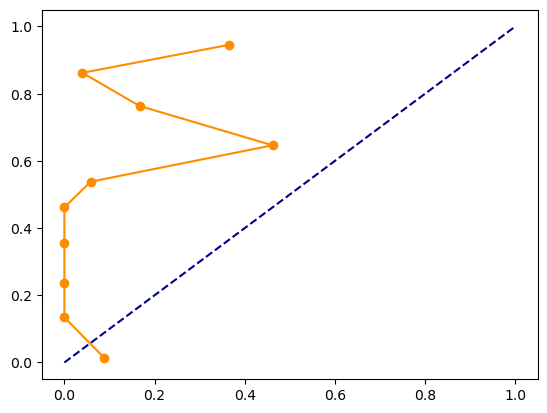

In [23]:

from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
test_predict = model.predict(test_X)
y_pred = np.argmax(model.predict(test_X),axis=1)
print('Recall: '+str(round(recall_score(test_y[:,1],y_pred),2)))
print('Precision: '+str(round(precision_score(test_y[:,1],y_pred),2)))
print('F1-score: '+str(round(f1_score(test_y[:,1],y_pred),2)))
print('Accuracy: '+str(round(accuracy_score(test_y[:,1],y_pred),2)))
print('Brier score:' +str(brier_score_loss(test_y[0:-20,1], test_predict[0:-20,1])))

calib_y, calib_x = calibration_curve(test_y[:,1],test_predict[:,1],n_bins=10)
visualization.plot_calibration_curve(calib_x, calib_y)

14/14 [==============================] - 0s 10ms/step
0.7699354317998387
(424,) (67,) (67,) (67,)


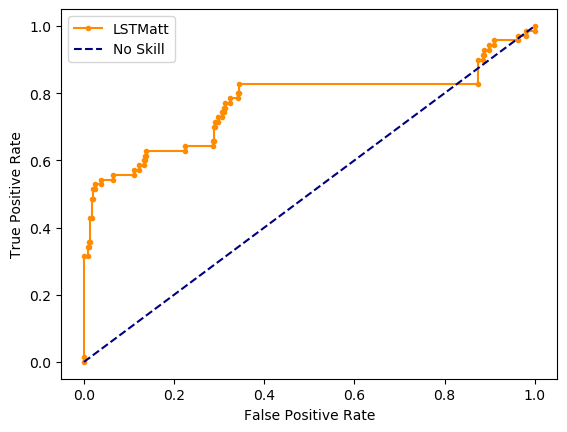

14/14 [==============================] - 0s 10ms/step
(424,) (425,) (425,)
f1=0.347 auc=0.642


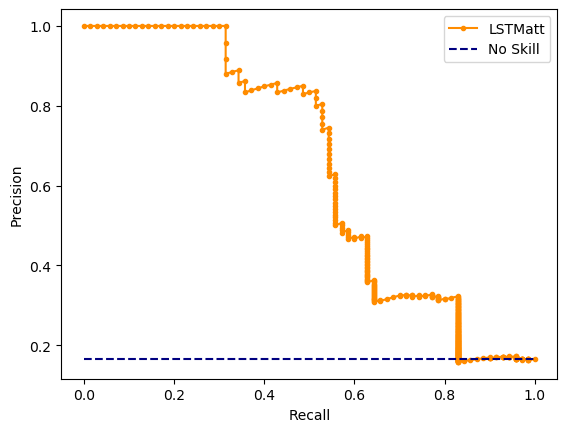

In [24]:
visualization.plot_roc_auc(model, test_X, test_y)

(444, 60, 20)
(444, 60)


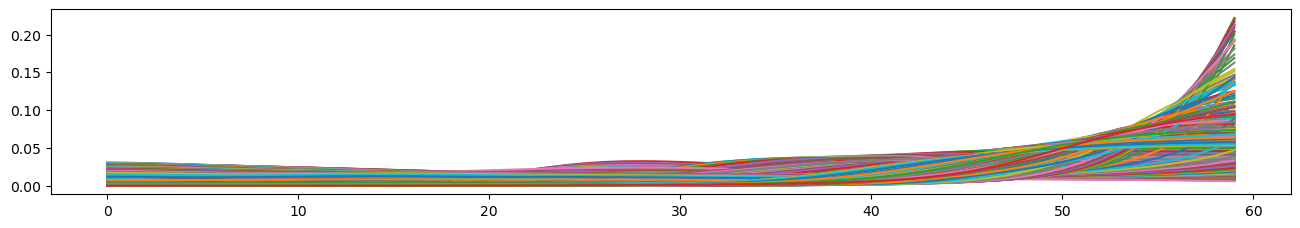

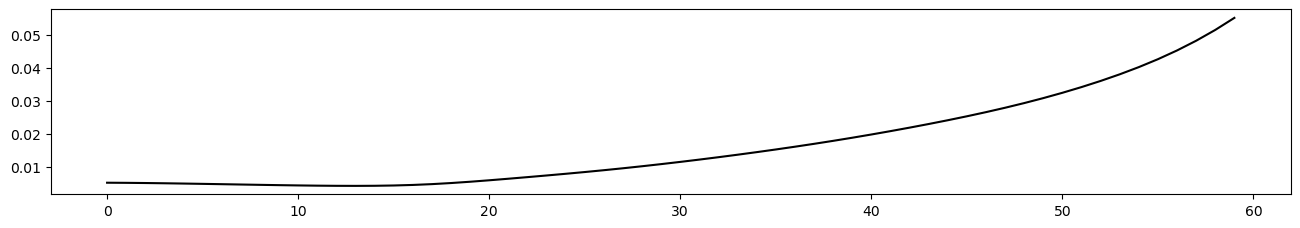

In [27]:
from tensorflow.keras.models import Model
# get weightings of each time step and each sample
intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=model.layers[3].output)

intermediate_layer_model1 = Model(inputs=model.input,
                                 outputs=model.layers[2].output)

intermediate_layer_model3 = Model(inputs=model.input,
                                 outputs=model.layers[4].output)

intermediate_output2, alfa_output = intermediate_layer_model2.predict(test_X, verbose=0)
intermediate_output1 = intermediate_layer_model1.predict(test_X, verbose=0)
intermediate_output3 = intermediate_layer_model3.predict(test_X, verbose=0)

weights = intermediate_output2 / intermediate_output1
print(np.shape(weights))

# plot the weights
val_weights = np.ndarray((len(test_X),ntimestep))+np.nan
for ii in range(len(test_X)):
    for j in range(ntimestep):
        val_weights[ii,j] = weights[ii][j][0]
print(np.shape(val_weights))

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
for ii in range(len(test_X)):
    plt.plot(val_weights[ii,:])

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.nanmean(val_weights,axis=0),'k')